<a href="https://colab.research.google.com/github/CalebAnderson22/PHY122/blob/main/Lab6_Anderson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lab 6

Caleb Anderson

30 November 2024

#   <font color='Green'> **Setup** </font>

In [136]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

π = np.pi

In [137]:
import scipy
from scipy.special import ellipj, ellipk

def get_radian(deg):
    return π * deg / 180

def get_degree(rad):
    return 180 * rad / π

def get_ω(time):
    dtt = time[1] - time[0]
    return 2*π * np.linspace(0.0, 1.0/(2.0*dtt), int(len(time)/2))

def get_Qdot(Q, L, IIi):

    ω = np.append([0.],  IIi @ L)

    B = 0.5*np.asarray([[ Q[0], -Q[1], -Q[2], -Q[3] ],
                        [ Q[1],  Q[0], -Q[3],  Q[2] ],
                        [ Q[2],  Q[3],  Q[0], -Q[1] ],
                        [ Q[3], -Q[2],  Q[1],  Q[0] ]])

    return B @ ω

def get_EulerAngles(Q):

    φ = np.arctan2( 2*(Q[0]*Q[1] + Q[2]*Q[3]) , 1 - 2*(Q[1]**2 + Q[2]**2) )
    θ = np.arcsin(  2*(Q[0]*Q[2] + Q[3]*Q[1] ) ) ## np.tan() ?? np.arcsin
    ψ = np.arctan2( 2*(Q[0]*Q[3] + Q[1]*Q[2]) , 1 - 2*(Q[2]**2 + Q[3]**2) )

    return np.asarray([φ, θ, ψ])

def get_Qauternions(Θ):

    φ = Θ[0]
    θ = Θ[1]
    ψ = Θ[2]

    ## Q[0] has all cosines, then for each component replace one sine, then add/subtract the flip of this
    Q = np.asarray([ np.cos(φ/2)*np.cos(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.sin(φ/2)*np.cos(θ/2)*np.cos(ψ/2) - np.cos(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.sin(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.cos(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.cos(θ/2)*np.sin(ψ/2) - np.sin(φ/2)*np.sin(θ/2)*np.cos(ψ/2)])

    return Q

def sn(arg, k):
    sn = scipy.special.ellipj( arg , k)[0]
    return np.nan_to_num(sn, nan=1.)


def EllipticK(k):
    return scipy.special.ellipk(k)


class PhysicalPendulum(object):
    # 6/30/21
    ''' Pendulum Initialization '''
    def __init__(self):

        ### Constants
        self.g    = 9.81 # meters/second-squared : gravitational acceleration
        self.L    = 1.00 # meters : moment-of-inertia length
        #self.R    = 1.00 # meters : rotation-arm length
        self.drag = 0.00 # kg/seconds : Stokes drag / viscous damping coefficient
        self.mass = 1.00 # kg

        ### calculated constants
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        ### calculations
        self.angle0      = None
        self.dynamicsrun = None
        self.dynamicst   = None
        self.freqprofile = None
        self.freq        = None

    def dynamics(self, Θ_0, dt=0.01, T=100, ω_0=[0.,0.,0.], error=0.25, dimension=1):

        ### calculated constants
        self.Θ    = Θ_0
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        self.angle0 = Θ_0
        Θ_0    = np.asarray([Θ_0, 0.0, 0.0])
        Θ_0    = get_radian(Θ_0)
        L      = self.II @ ω_0
        time   = np.arange(0, T, dt)
        Q      = get_Qauternions(Θ_0)
        θ_data = np.zeros( (time.shape[0], 3) )

        for i in range(len(time)):

            θ_data[i] = get_degree( get_EulerAngles(Q) + (Θ_0[0]/180) * error*(np.random.rand(3) - 0.5) )

            τ = self.II @ ( - self.C2 @ np.sin(get_EulerAngles(Q)) - self.C1 @ ( self.IIi @ L ) ) ## leave τ & L in Euler angles!

            L_t = L + dt * τ / 2
            L   = L + dt * τ

            Qdot_t = get_Qdot(Q, L_t, self.IIi)
            Qdt = Q + dt/2 * Qdot_t

            Qdot_tdt = get_Qdot(Qdt, L, self.IIi)
            Q = Q + dt * Qdot_tdt

        self.dynamicst   = time
        self.dynamicsrun = (θ_data[:,:dimension].T)[0]

        return self.dynamicst , self.dynamicsrun

    def frequency(self):
        self.freq   = get_ω(self.dynamicst)
        self.freqprofile = np.abs(2.0/len(self.dynamicst) * (np.fft.fft( self.dynamicsrun, axis=0 ))[:len(self.dynamicst)//2])
        self.getmax = self.freq[np.argmax(self.freqprofile)]
        return self.freq / (2 * np.pi), self.freqprofile

    def exactdynamics(self):
        t = self.dynamicst

        k  = np.sin( get_radian(self.angle0)/2 )**2
        K  = scipy.special.ellipk(k)
        Θt  = self.angle0 * sn(self.ω0 * t + K , k)

        return Θt

#   <font color='Red'> **Getting Started** </font>

####   <font color='Red'> To get started, let's define a pendulum object </font>

In [138]:
Experiment = PhysicalPendulum()

####   <font color='Red'> Next, let's change the objects: mass, L (length), gravity. </font>

In [139]:
Experiment.L = 1
Experiment.mass = 10
Experiment.g = 9.81

####   <font color='Red'> Next, let's run the dynamics with an ideal release angle of your choice (in degrees). </font>

In [140]:
t, Θ_t = Experiment.dynamics(5, error=0.0, dt=0.1, T = 100)

####   <font color='Red'> Next, let's plot our dynamics results. </font>

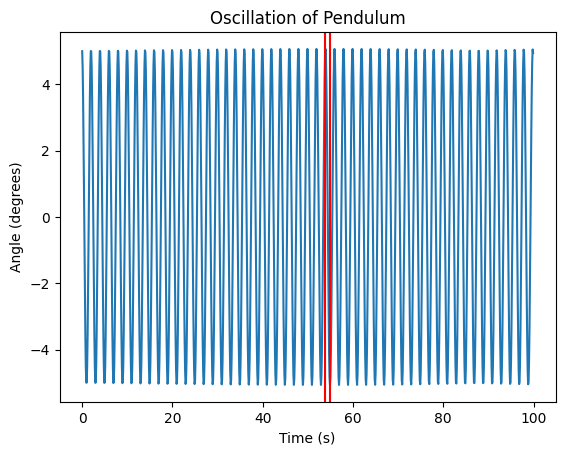

In [141]:
plt.plot(t, Θ_t)
plt.axvline(x=53.9, color='red')
plt.axvline(x=54.9, color='red')
plt.title("Oscillation of Pendulum")
plt.xlabel("Time (s)")
plt.ylabel("Angle (degrees)")
plt.show()

This graph depicts the angular motion of a simple pendulum over time. Initial conditions were a release angle of 5°, mass 10 kg, gravitational acceleration 9.81 m/s^2, and length 1 m. The red lines pick out a relative maximum and minimum, the time between each being a half-period, as symmetry requires the exact same amount of time for the pendulum to return to its maximum. Notice how in the absence of air resistance, friction, or any other non-conservative forces, the amplitude does not diminish even as time goes on. Also notice how the amplitude is equivalent to its release angle.

###   <font color='Red'> Determine-and-Print the Period & the frequency of the plot above, using only the graph (and data above): </font>

In [142]:
print(np.max(Θ_t))
print(np.min(Θ_t))
print(np.where(Θ_t == np.max(Θ_t)))
print(np.where(Θ_t == np.min(Θ_t)))

5.067993136673078
-5.068014157612662
(array([539]),)
(array([549]),)


Half-period between t=53.9 s and t=54.9 s. Therefore, full period is 2 s. Frequency and period are inversely related (T=1/f, where here T=2 s), so f = 0.5 Hz.

###   <font color='Red'> Next lets determine the frequency-profile of this simulation: </font>

In [143]:
f, S = Experiment.frequency()
S_peak = np.max(S)
S_peak_index= np.argmax(S)
freq_peak = f[S_peak_index]
print(freq_peak)
print("Percent diff between theory and data = " + str(abs(freq_peak - 0.5)/0.5*100) + "%")

0.501002004008016
Percent diff between theory and data = 0.2004008016031955%


This result is consistent with our estimate of 0.5 Hz from eyeballing the period on the graph. As a matter of fact, it is *very* consistent, off by a fraction of one percent.

#   <font color='Red'> **Mass Experiment** </font>

### <font color='Green'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [144]:
Masses = np.arange(0.1, 10, 0.1)
f1  = np.empty(len(Masses))

for i in range(len(Masses)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 1 ## m
    MassExperiment.mass = Masses[i] ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    f1[i] = f[np.argmax(S)]

###   <font color='Red'> Next let's plot our results: </font>

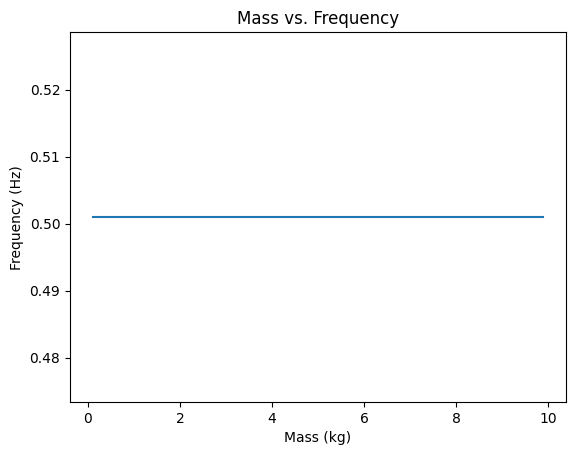

In [145]:
plt.plot(Masses, f1)
plt.title("Mass vs. Frequency")
plt.xlabel("Mass (kg)")
plt.ylabel("Frequency (Hz)")
plt.show()

In Experiment 1 we have the smae initial conditions as the starter pendulum, only we vary the mass from 0.1 kg to 10 kg. Notice how the frequency is constant despite the increasing mass. This means frequncy has no dependence on mass; given a simple, frictionless pendulum in a vacuum, all else being equal, it would not matter if the mass was equivalent to a feather or an elephant. This is a noteworthy result, as it is unintuitive, but deeply tied to the constant acceleration of gravity under just such ideal conditions.

#   <font color='Red'> **Length Experiment** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [146]:
Lengths = np.arange(0.1, 10, 0.1)
f2  = np.empty(len(Lengths))

for i in range(len(Lengths)):

    LengthExperiment = PhysicalPendulum()
    LengthExperiment.L    = Lengths[i] ## m
    LengthExperiment.mass = 1 ## kg
    LengthExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = LengthExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = LengthExperiment.frequency()

    f2[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

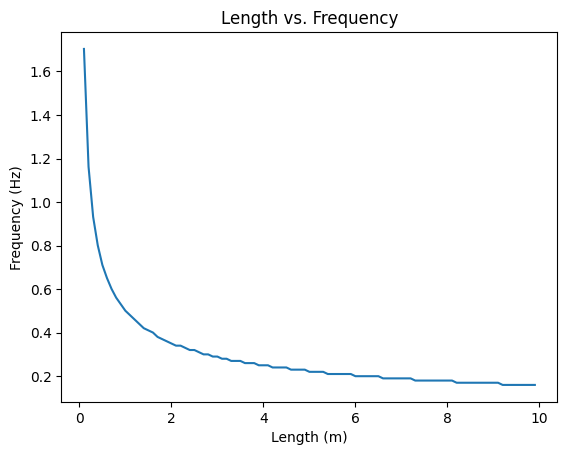

In [147]:
plt.plot(Lengths, f2)
plt.title("Length vs. Frequency")
plt.xlabel("Length (m)")
plt.ylabel("Frequency (Hz)")
plt.show()

This plot takes the same simple pendulum from the start and varieds its length between 0.1 m and 10 m. This time there is a stark relationship. However, this is perfectly consistent with theory, as T = 2π/ω, where ω is the square root of the quotient of length and gravitational acceleration, and T is the period, which is the inverse of the frequency. Therefore, the decreasing root graph validates the theory, given that all other variables are being held constant.

###   <font color='Red'> Let's plot our results in a linearized form: </font>

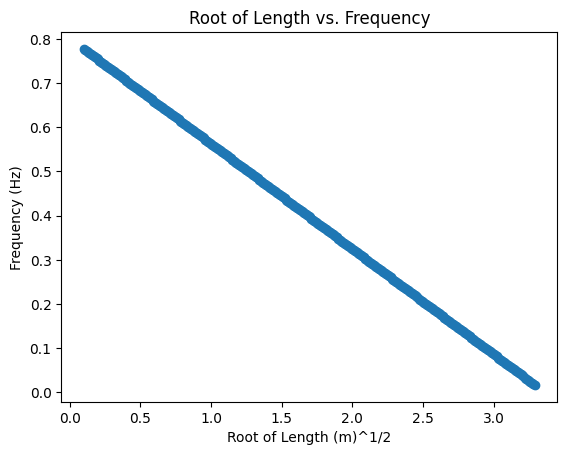

In [148]:
def linearfit(x,y):
  A = np.vstack([x, np.ones(len(x))]).T
  return np.linalg.lstsq(A, y, rcond=None)[0]
sqlengths=np.sqrt(Lengths)
linearlength = linearfit(sqlengths, f2)
x=np.arange(0.1,3.3,0.01)
plt.scatter(x, linearlength[0]*x + linearlength[1])
plt.title("Root of Length vs. Frequency")
plt.xlabel("Root of Length (m)^1/2")
plt.ylabel("Frequency (Hz)")
plt.show()

This linear fit shows an inverse relationship between the root of a simple pendulum's length and the frequency of its oscillation. It makes clear what is implied by the previous graph, which was simply Length v. Frequency and thus included the root behavior. However, accounting for the root behavior makes the linear inverse relationship between frequency and length more obvious. The pendulum used here has all the same initial conditions, constants, and range of lengths as the first run for this experiment.

#   <font color='Red'> **Gravitational Acceleration** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [149]:
Gs = np.arange(0.1, 10, 0.1)
f3  = np.empty(len(Gs))

for i in range(len(Gs)):

    GExperiment = PhysicalPendulum()
    GExperiment.L    = 10 ## m
    GExperiment.mass = 1 ## kg
    GExperiment.g    = Gs[i] ## m/s/s

    t, Θ_t = GExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = GExperiment.frequency()

    f3[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

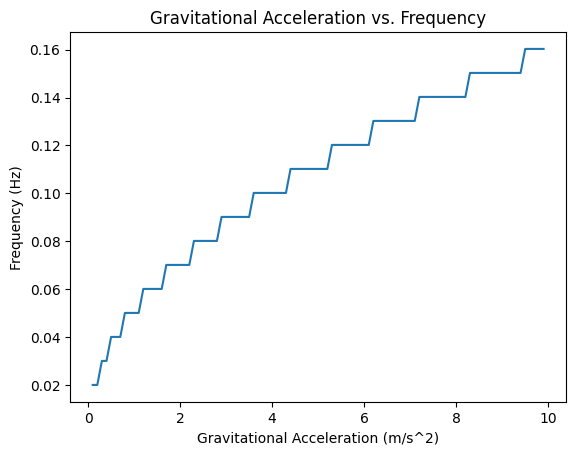

In [150]:
plt.plot(Gs, f3)
plt.title("Gravitational Acceleration vs. Frequency")
plt.xlabel("Gravitational Acceleration (m/s^2)")
plt.ylabel("Frequency (Hz)")
plt.show()

This plot takes the same simple pendulum from the start and varies the gravitational acceleration it experiences between 0.1 m/s^2 and 10 m/s^2, the latter being much closer to Earth's gravitational acceelration. There is again a stark relationship. It is also still consistent with theory, as T = 2π/ω, where ω is the square root of the quotient of length and gravitational acceleration, and T is the period, which is the inverse of the frequency. Therefore, the increasing root graph validates the theory, given that all other variables are being held constant.

###   <font color='Red'> Let's plot our results in linearized form: </font>

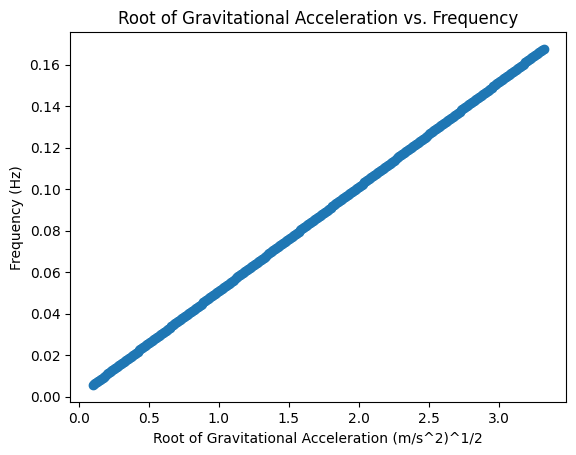

In [151]:
sqGs=np.sqrt(Gs)
linearg=linearfit(sqGs, f3)
x=np.arange(0.1,3.33,0.01)
plt.scatter(x, linearg[0]*x + linearg[1])
plt.title("Root of Gravitational Acceleration vs. Frequency")
plt.xlabel("Root of Gravitational Acceleration (m/s^2)^1/2")
plt.ylabel("Frequency (Hz)")
plt.show()

This linear fit shows proportional increase between the root of gravitational acceleration and frequency. It makes clear what is implied by the previous graph, which was simply Gravitational Acceleration v. Frequency and thus included the root behavior. However, accounting for the root behavior makes the linear, positive relationship between frequency and the root of gravity more obvious. The pendulum used here has all the same initial conditions, constants, and range of lengths as the first run for this experiment.

#   <font color='Red'> **Release Angle (small)** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [152]:
Thetas = np.arange(0.1, 5, 0.1)
f4  = np.empty(len(Thetas))

for i in range(len(Thetas)):

    TExperiment = PhysicalPendulum()
    TExperiment.L    = 10 ## m
    TExperiment.mass = 5 ## kg
    TExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = TExperiment.dynamics(Thetas[i], error=0.0, dt=0.1, T = 100)
    f, S   = TExperiment.frequency()

    f4[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

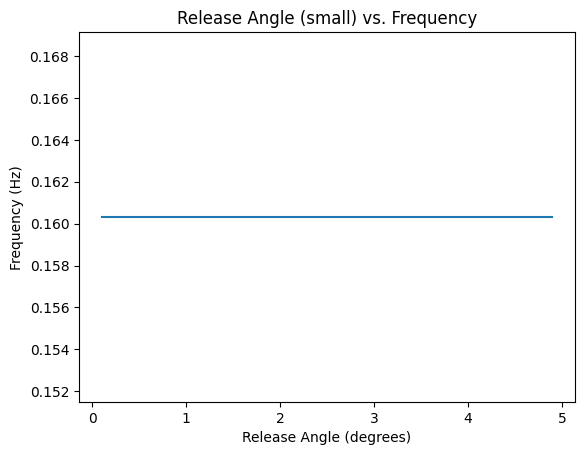

In [153]:
plt.plot(Thetas, f4)
plt.title("Release Angle (small) vs. Frequency")
plt.xlabel("Release Angle (degrees)")
plt.ylabel("Frequency (Hz)")
plt.show()

Finally, we come to the last manipulable variable for a simple pendulum, the release angle. We are shown the same thing as with mass - that varying the release angle (small) simply has no effect on the period/frequency of its oscillation. It certainly dictates its amplitude, as we saw in the starter example that the pendulum oscillated with an amplitude equivalent to its release angle. However, though it may be counterintuitive, the dependence amplitude has on release angle implies nothing for period/frequency. This validates the theory, as discussed in previous experiments the only manipulable variables that the period/frequency of a simple pendulum can be dependent on are its length and the gravitational acceleration it experiences.

#   <font color='Red'> **Conclusion** </font>

Based on the theory presented in the prompt, these experiments turned out as expected. Experiment 1 showed that mass plays no part in the period or frequency of a simple pendulum, just as the equation T = 2π/ω, where ω is the square root of the quotient of length and gravitational acceleration, implies. Still, this is a noteworthy result since it is an unintuitive one.
Experiment 4 similarly showed a null relationship between release angle and period/frequency, another unintuitive result but one predicted by the theory.

Experiments 2 and 3 further validated the theory not just by showing *a* relationship between period/frequency and length and gravitational acceleration, respectively, but *the* predicted relationship. The aforementioned equation, all else being constant, holds frequency inversely proportional to the square root of the length of the pendulum. What do we see in our graph in Experiment 2? An exponentially decreasing relationship between frequency and length. In Experiment 3, our graph (however rough it is) still generally holds to the positive root function, just astheory predicts frequency to be proportional to the square root of g all else being constant.

#   <font color='Red'> **Describe the Small Angle Approximation** </font>

The small angle approximation enables easier calculation of nonliner (i.e., sinusoidal) relationships given that for very small values of θ, the Taylor-Maclaurin series for sinθ has trivially small contributions from every term after the first term, which is simply θ. Thus, though it is always valid to express sinθ by its series approximation, for very small θ it is further appropriate to reduce the approximation itself down to a single, linear term. Given that the physical circumstances are appropriate, this can save a lot of unneccessary headache and computational expenditure for the physical scientist.

#   <font color='Red'> **What happens at θ_0 = 0° and θ_0 = 180°? What is the period/frequency?** </font>

At these unique initial conditions, θ_0 = 0° and θ_0 = 180°, the gravitational and would-be centripetal acceleration are anti-parallel and parallel, respectively. The pendulum thus remains still for all time (given an ideal set of circumstances, of course). Since the pendulum stays still for all time, it never completes an oscillation, meaning its period is effectively infinity seconds . Given a period of infinity seconds, the frequency is 0 Hz.